### The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2353 non-null   int64  
 1   bed             2353 non-null   float64
 2   bath            2353 non-null   float64
 3   acre_lot        2353 non-null   float64
 4   zip_code        2353 non-null   float64
 5   house_size      2353 non-null   float64
 6   prev_sold_date  2353 non-null   object 
 7   price           2353 non-null   float64
 8   prev_sold_year  2353 non-null   int64  
 9   zip_code_str    2353 non-null   int64  
 10  latitude        2353 non-null   float64
 11  longitude       2353 non-null   float64
 12  county          2353 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 239.1+ KB


#### Create an object to pass to the function that will normalize the data

In [4]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
2348,2348,3.0,3.0,2.75,18470.0,1913.0,2020-09-08,349999.0,2020,18470,41.724706,-75.535516,2
2349,2349,3.0,2.0,4.55,18470.0,1152.0,2021-03-23,59000.0,2021,18470,41.724706,-75.535516,2
2350,2350,2.0,2.0,0.05,18421.0,1946.0,2022-02-25,85000.0,2022,18421,41.664210,-75.492886,2
2351,2351,2.0,1.0,0.17,18472.0,471.0,2021-08-31,98500.0,2021,18472,41.583410,-75.396687,2
2352,2352,3.0,2.0,0.21,18821.0,1175.0,2020-12-28,114500.0,2020,18821,41.989756,-75.722751,2


#### Create a variable for the correlation of the normalized data

In [5]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.077694
bed               0.193403
bath              0.571221
house_size        0.566448
prev_sold_year   -0.129353
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

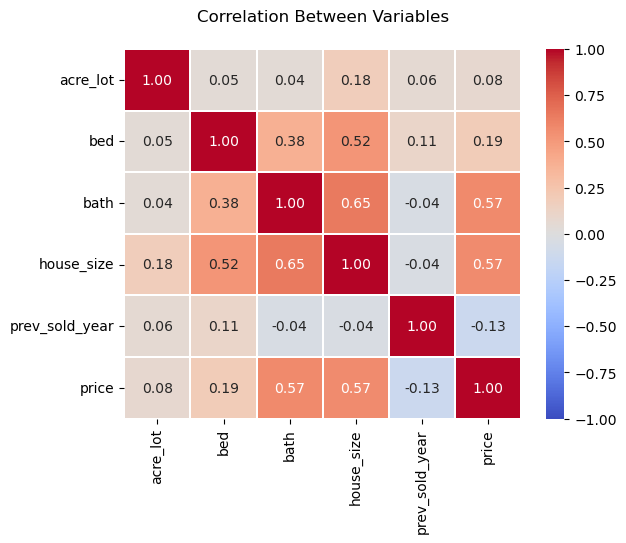

In [6]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [7]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [8]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Lasso Regression

In [12]:
myrange = []
for i in range(12,17):
    myrange.append(10**-i)
param_dict = {'alpha': myrange}
lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 1e-12}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
lasso_bp = dosomething("Lasso","Best Params", normalize_df, features, "price", lasso_gscv.best_params_)
results_dict_append(lasso_bp["results"])
lasso_bp_predict = lasso_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'bath', 'house_size']
Best Params EVS = 0.443753983
Best Params MSE = 33,830,500,649.904182
Best Params MAE = 117,157.827117
Best Params R2 = 0.442896
Best Params Fit Time = 0.00387115478515625


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [14]:
lasso_sfm = dosomething("Lasso","Select From Model", normalize_df, features, "price")
results_dict_append(lasso_sfm["results"])
lasso_sfm_predict = lasso_sfm["predictions"]

The selected features are: ['latitude', 'longitude', 'bath', 'house_size']
Select From Model EVS = 0.443754444
Select From Model MSE = 33,830,474,332.350510
Select From Model MAE = 117,157.256678
Select From Model R2 = 0.442897
Select From Model Fit Time = 0.001027822494506836


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
lasso_sfs = dosomething("Lasso","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(lasso_sfs["results"])
lasso_sfs_predict = lasso_sfs["predictions"]

The selected features are: ['latitude', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.442031881
Sequential Feature Selector MSE = 33,936,504,834.768364
Sequential Feature Selector MAE = 116,733.795265
Sequential Feature Selector R2 = 0.441151
Sequential Feature Selector Fit Time = 0.0006070137023925781


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [16]:
lasso_rfe = dosomething("Lasso","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(lasso_rfe["results"])
lasso_rfe_predict = lasso_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bath']
Recursive Feature Elimination EVS = 0.350797948
Recursive Feature Elimination MSE = 39,501,383,743.752403
Recursive Feature Elimination MAE = 128,798.728337
Recursive Feature Elimination R2 = 0.349511
Recursive Feature Elimination Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

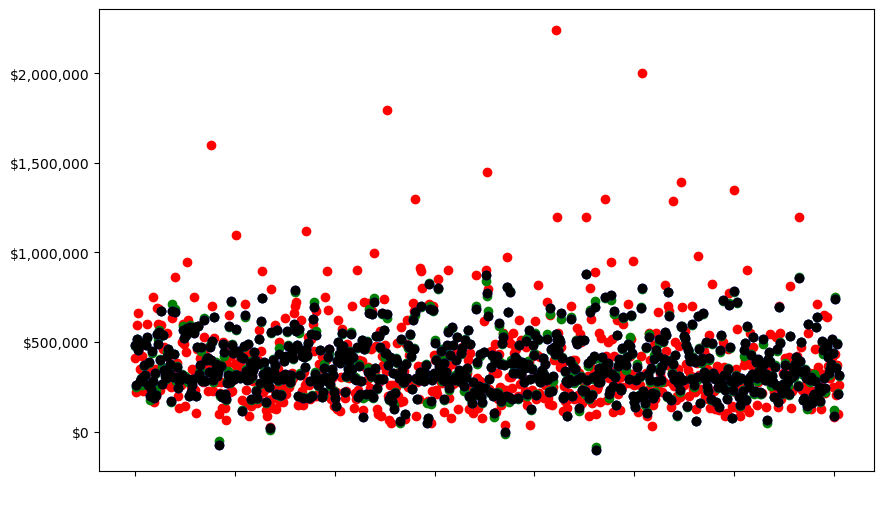

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="green")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="blue")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.443753983',
  '0.443754444',
  '0.442031881',
  '0.350797948'],
 'mae score': ['117,157.827117',
  '117,157.256678',
  '116,733.795265',
  '128,798.728337'],
 'mse score': ['33,830,500,649.904182',
  '33,830,474,332.350510',
  '33,936,504,834.768364',
  '39,501,383,743.752403'],
 'r2 score': ['0.442896', '0.442897', '0.441151', '0.349511'],
 'mean fit time': [0.00387115478515625,
  0.001027822494506836,
  0.0006070137023925781,
  0.0]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.443753983,"117,157.827117","33,830,500,649.904182",0.442896,0.003871
Select From Model,0.443754444,"117,157.256678","33,830,474,332.350510",0.442897,0.001028
Sequential Feature Selector,0.442031881,"116,733.795265","33,936,504,834.768364",0.441151,0.000607
Recursive Feature Elimination,0.350797948,"128,798.728337","39,501,383,743.752403",0.349511,0.000000
